In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from gen_data import CartPoleDynamics

In [2]:
# Read in the model parameters from the top of the data file
with open("../data/data.csv", "r") as f:
    params = dict([(param, float(val)) for (param, val) in [pair.split('=') for pair in f.readline().split(',')]])

In [3]:
# Read in the dataset from the CSV file
df = pd.read_csv("../data/data.csv", skiprows=1)

In [4]:
# Separate the dataset into the group, features, and target variable
grp = df["group"]
X = df.drop(columns=["group", "u"])
y = df["u"]

In [5]:
# Define a Tranformer to add dynamics features
class DynamicsTransformer(BaseEstimator, TransformerMixin):
    """Adds derivative of state as additional features"""
    def __init__(self, dyn, u_range):
        # Save the dynamics object
        self.dyn = dyn
        
        # Save the range of inputs for computing the accelerations
        self.u_range = u_range
    
    def transform(self, df, y=None):
        # Allocate arrays for the accerlations
        z_ddot = np.zeros(len(df))
        theta_ddot = np.zeros(len(df))
        
        # Compute accelerations for each possible control in the control range
        for j in range(len(self.u_range)):
            # Compute the acceleration for each point
            for i in range(len(df)):
                # Compute acceleration for the point with the control
                dxdt = self.dyn.f(0., df.iloc[i,0:4].to_numpy(), np.array([self.u_range[j]]))
                
                # Place the results of the acceleration in the allocated arrays
                z_ddot[i] = dxdt[2]
                theta_ddot[i] = dxdt[3]
                
            # Add the acceleration arrays as columns in the dataset
            df["z_ddot_{}".format(j)] = z_ddot
            df["theta_ddot_{}".format(j)] = theta_ddot
            
        # Return the augemented features
        return df
    
    def fit(self, df, y=None):
        return self

In [6]:
# Define the dynamics of the cart-pole system
dyn = CartPoleDynamics(**params)

# Define the range of control inputs to test for the dynamics
num_u = 21
u_range = np.linspace(-10, 10, num_u)

# Augment the features with acceleration information
dynamics_transformer = DynamicsTransformer(dyn, u_range)
#X = dynamics_transformer.fit_transform(X)

In [20]:
random_state = 0

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
model = Pipeline([("ss", StandardScaler()),
                  ("nn", MLPRegressor(hidden_layer_sizes=(10,), random_state=random_state, max_iter=1000))])
                  
from sklearn.model_selection import GroupShuffleSplit
train_idx, test_idx = next(GroupShuffleSplit(test_size=0.90, random_state=random_state).split(X, y, grp))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
grp_train, grp_test = grp[train_idx], grp[test_idx]

from tqdm import tqdm
from sklearn.model_selection import GroupKFold, GridSearchCV
gs_params = {'nn__alpha':np.logspace(-5, 1, 5)}
splitter = GroupKFold(n_splits=10)
gs = GridSearchCV(model, param_grid=gs_params, cv=splitter, verbose=99, n_jobs=-1, return_train_score=True)
gs.fit(X_train, y_train, groups=grp_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   1

GridSearchCV(cv=GroupKFold(n_splits=10),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('nn',
                                        MLPRegressor(hidden_layer_sizes=10,
                                                     max_iter=1000,
                                                     random_state=0))]),
             n_jobs=-1,
             param_grid={'nn__alpha': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01])},
             return_train_score=True, verbose=99)

[]

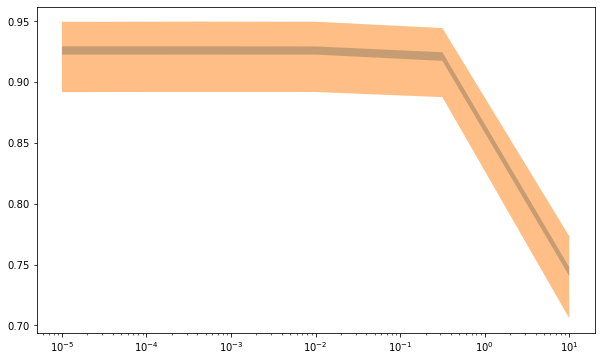

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.fill_between(gs_params["nn__alpha"], gs.cv_results_["mean_train_score"] - gs.cv_results_["std_train_score"], 
                                         gs.cv_results_["mean_train_score"] + gs.cv_results_["std_train_score"],
                 alpha=0.5)
plt.fill_between(gs_params["nn__alpha"], gs.cv_results_["mean_test_score"] - gs.cv_results_["std_test_score"], 
                                         gs.cv_results_["mean_test_score"] + gs.cv_results_["std_test_score"],
                 alpha=0.5)
plt.semilogx()

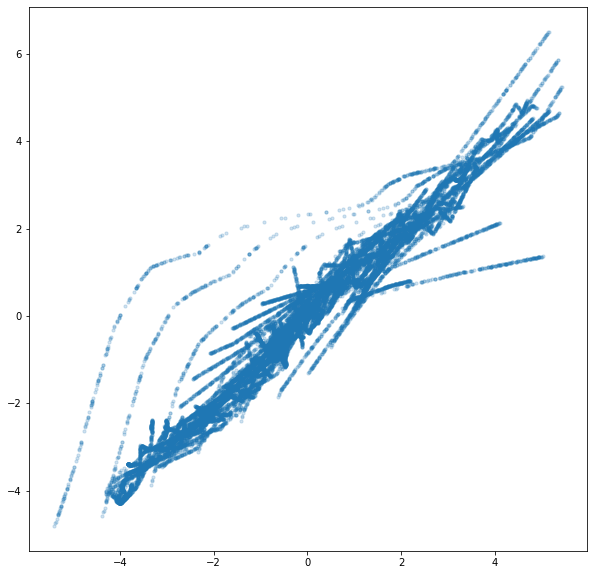

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, gs.predict(X_test), alpha=0.2, s=10)

In [23]:
gs.best_score_

0.920750889908477